# Report figures notebook

In [100]:
import os

import time
import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import nibabel as nib
import neurite as ne
import voxelmorph as vxm
import mpl_toolkits.axisartist as AA
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

from stabilize2p.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    low, hig = video[0].min(), video[1].max()
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif'
]

ofco_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
]

RANDOM_SEED = 1

os.makedirs('report', exist_ok=True)

# Title

In [52]:
from stabilize2p.metrics import MSE
image = tiff.imread(orig_examples[0])

MSE(image, ref='first', return_all=True).argmax()

1438

In [5]:
from stabilize2p.utils import get_strategy
os.makedirs('report/title', exist_ok=True)

strategy = get_strategy('GPU')


# retrieve dataset shape
in_shape = tiff.imread(orig_examples[0], key=0).shape

# unet architecture
enc_nf = [16, 32, 32, 128, 128]
dec_nf = [128, 128, 32, 32, 32, 16, 16]


# build model using VxmDense
with strategy.scope():
    vxm_model = vxm.networks.VxmDense(in_shape, [enc_nf, dec_nf], int_steps=0)
    vxm_model.load_weights('../models/vxm_drosophila_2d_1000.h5')

[2021-12-08 18:05:40,669] I T140456538862400 utils.py:840: Num Physical GPUs Available: 1
[2021-12-08 18:05:40,669] I T140456538862400 utils.py:841: Num Logical  GPUs Available: 1
[2021-12-08 18:05:40,670] I T140456538862400 utils.py:842: Num TPUs Available: 0
[2021-12-08 18:05:40,670] W T140456538862400 utils.py:852: GPU device "PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')" is already initialized.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


[2021-12-08 18:05:40,672] I T140456538862400 utils.py:868: using GPU "MirroredStrategy" strategy.


In [53]:
from stabilize2p.utils import vxm_data_generator

store_params = []
val_generator = vxm_data_generator(orig_examples[0],
                                   batch_size=8,
                                   keys=[[1, 1438]],
                                   training=False,
                                   ref='first',
                                   store_params=store_params)

val_pred = []
for (val_input, _) in val_generator:
    val_pred += [vxm_model.predict(val_input, verbose=2)]
val_pred = [
    np.concatenate([a[0] for a in val_pred], axis=0),
    np.concatenate([a[1] for a in val_pred], axis=0)
]

# undo pre-processing
params = store_params[0]
h, l = params.pop('hig'), params.pop('low')
val_pred[0] = val_pred[0] * (h - l) + l
val_pred[0] = np.exp(val_pred[0]) - 1
val_pred[0] = val_pred[0] + params['bg_thresh']

val_pred[0].shape, val_pred[1].shape

[2021-12-08 18:29:44,809] I T140456538862400 utils.py:162: Calculated "first" fixed references in 0.00654s


1/1 - 0s - 36ms/epoch - 36ms/step


2021-12-08 18:29:44.901524: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3551"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:109"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. Yo

((2, 480, 736, 1), (2, 480, 736, 2))

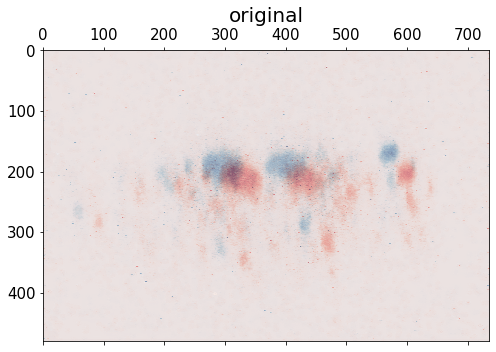

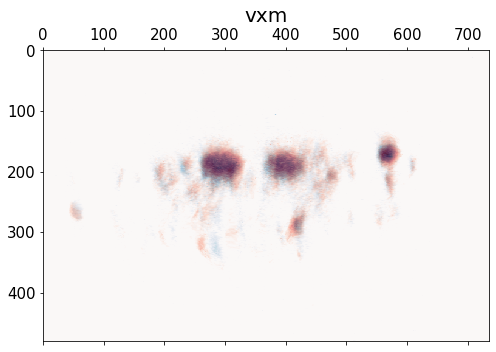

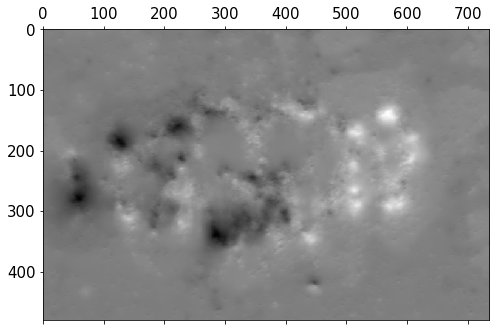

(480, 736, 1)


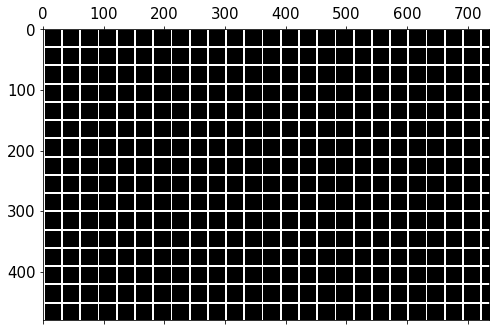

grid.shape=(1, 480, 736, 1)
in_shape=(480, 736)
warp.shape=(1, 480, 736, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deform_field.shape=(1, 480, 736, 1)


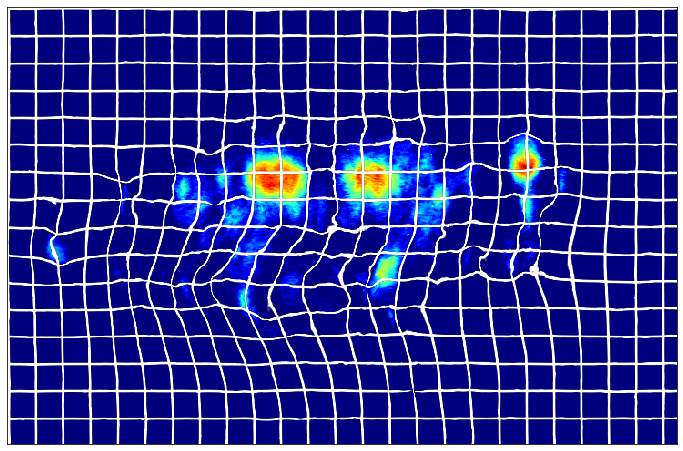

In [64]:
image = tiff.imread(orig_examples[0], key=[1, 1438])

_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(image[0], cmap='Blues')
ax.matshow(image[1], cmap='Reds', alpha=0.5)
ax.set_title('original')
plt.show()

_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(val_pred[0][0, ..., 0], cmap='Blues')
ax.matshow(val_pred[0][1, ..., 0], cmap='Reds', alpha=0.5)
ax.set_title('vxm')
plt.show()

_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(val_pred[1][1, ..., 0], cmap='gray')
plt.show()

sh = val_pred[0].shape[1:]
print(sh)
grid = np.zeros(sh)
ds = 30
grid[::ds, :] = 1.0
grid[1::ds, :] = 1.0
grid[2::ds, :] = 1.0
grid[:, ::ds] = 1.0
grid[:, 1::ds] = 1.0
grid[:, 2::ds] = 1.0
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(grid, cmap='gray')
plt.show()

grid = grid[np.newaxis, ...]
print(f'{grid.shape=}')
print(f'{in_shape=}')
warp = val_pred[1][1][np.newaxis, ...]
print(f'{warp.shape=}')

deform_field = vxm.networks.Transform(in_shape, nb_feats=1)\
        .predict([grid, warp])
print(f'{deform_field.shape=}')

deform_field = np.tile(deform_field[0], (1, 1, 4))
# deform_field[..., 3] = deform_field[..., 

_, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.matshow(val_pred[0][1], cmap='jet')
ax.matshow(deform_field, cmap='gray')
ax.tick_params(left=False,
                bottom=False,
                top=False,
                labeltop=False,
                labelleft=False,
                labelbottom=False)
plt.savefig('report/title/title.svg')
plt.show()

# Dataset overview

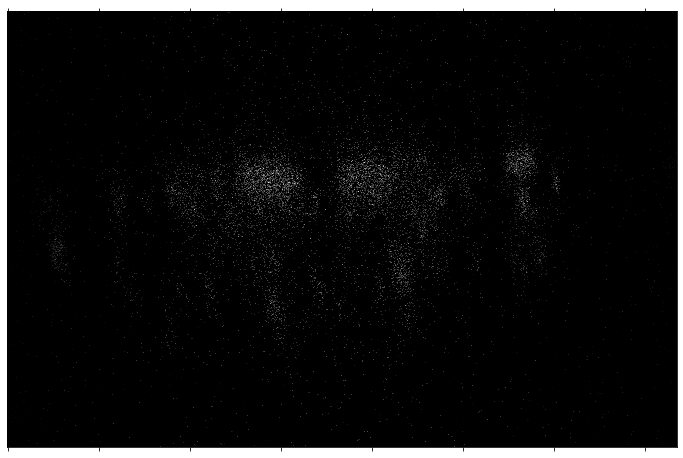

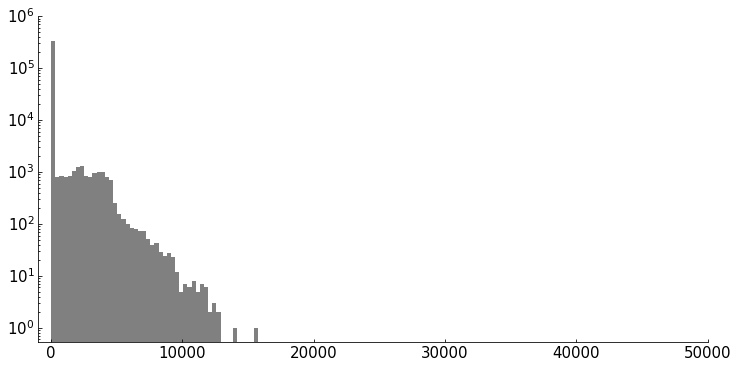

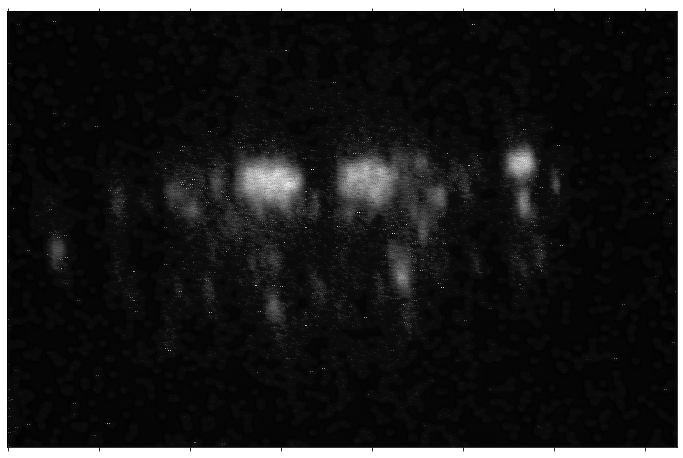

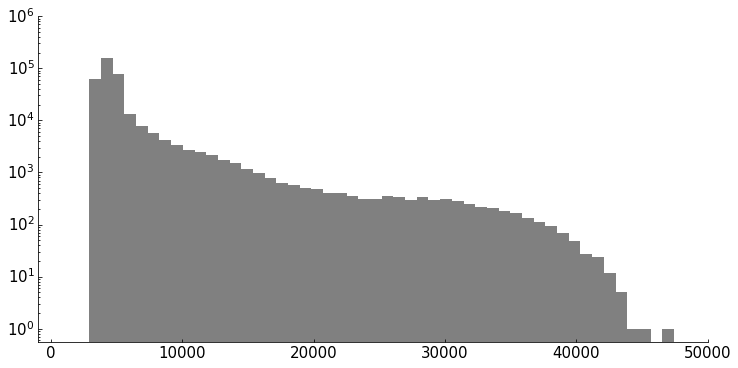

In [37]:
os.makedirs('report/dataset-overview', exist_ok=True)

def plot(path, name):
    img = tiff.imread(path, key=0)
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(1,1,1)
    ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    ax.matshow(img, cmap='gray')

    plt.savefig(f'report/dataset-overview/{name}.svg')
    plt.show()

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1, axes_class=AA.Axes)
    for direction in ["right", "top"]:
        # hides borders
        ax.axis[direction].set_visible(False)
    ax.set_yscale('log')
    ax.hist(img.ravel(), bins=50, color='gray')
    ax.set_ylim(None, 1e6)
    ax.set_xlim(-1000, 50_000)

    plt.savefig(f'report/dataset-overview/{name}-hist.svg')
    plt.show()
    

path = '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/red.tif'
plot(path, 'raw')



path = '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif'
plot(path, 'denoised')

# Metrics

In [65]:
from stabilize2p.utils import plot_centers

os.makedirs('report/metrics', exist_ok=True)

x: 367.82 + 1.11
y: 237.14 + 0.80
x: 366.77 + 2.40
y: 234.94 + 1.47
x: 366.98 + 0.72
y: 238.18 + 0.62
x: 366.47 + 0.84
y: 239.50 + 0.44
x: 365.36 + 1.89
y: 240.88 + 1.11
x: 365.75 + 0.96
y: 237.39 + 1.58
x: 365.39 + 1.81
y: 238.58 + 1.09
x: 364.53 + 2.81
y: 240.75 + 1.14
x: 370.25 + 1.24
y: 240.52 + 0.57


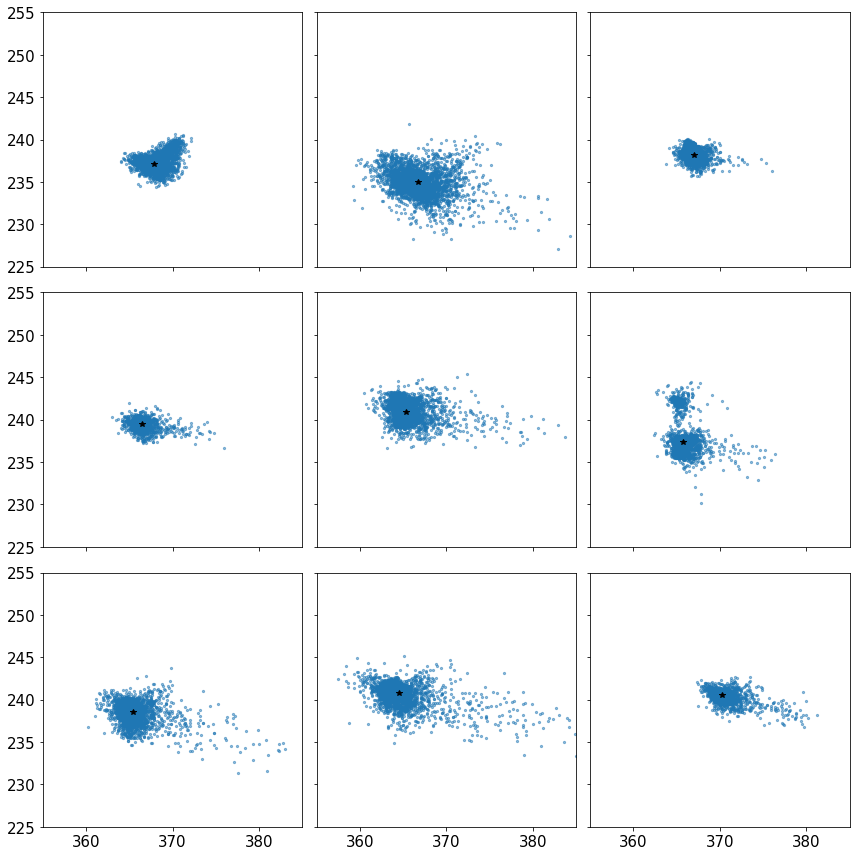

In [85]:
from stabilize2p.utils import get_centers


_, axes = plt.subplots(3, 3, figsize=(4*3, 4*3), sharex='all', sharey='all')

for i, ax in enumerate(axes.ravel()):
    image = tiff.imread(orig_examples[i])
    # centers = get_centers(image)
    # m_centers = centers.mean(axis=0)
    # radius = np.mean(np.sqrt(np.sum((centers - m_centers)**2, axis=1)))
    # print(f'{radius=}')
    plot_centers(image, radius=0, ax=ax, title='')
    ax.set_xlim(355, 385)
    ax.set_ylim(225, 255)

plt.tight_layout()
plt.savefig('report/metrics/com-example.png')

# Thresholding

In [88]:
from stabilize2p import threshold

os.makedirs('report/thresholding', exist_ok=True)

methods = [
    threshold.otsu,
    threshold.triangle,
    threshold.watershed,
    threshold.second_deriv
]

path='../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_green.tif'
otsu: $T=385$
triangle: $T=267$
watershed: $T=186$
second_deriv: $T=202$


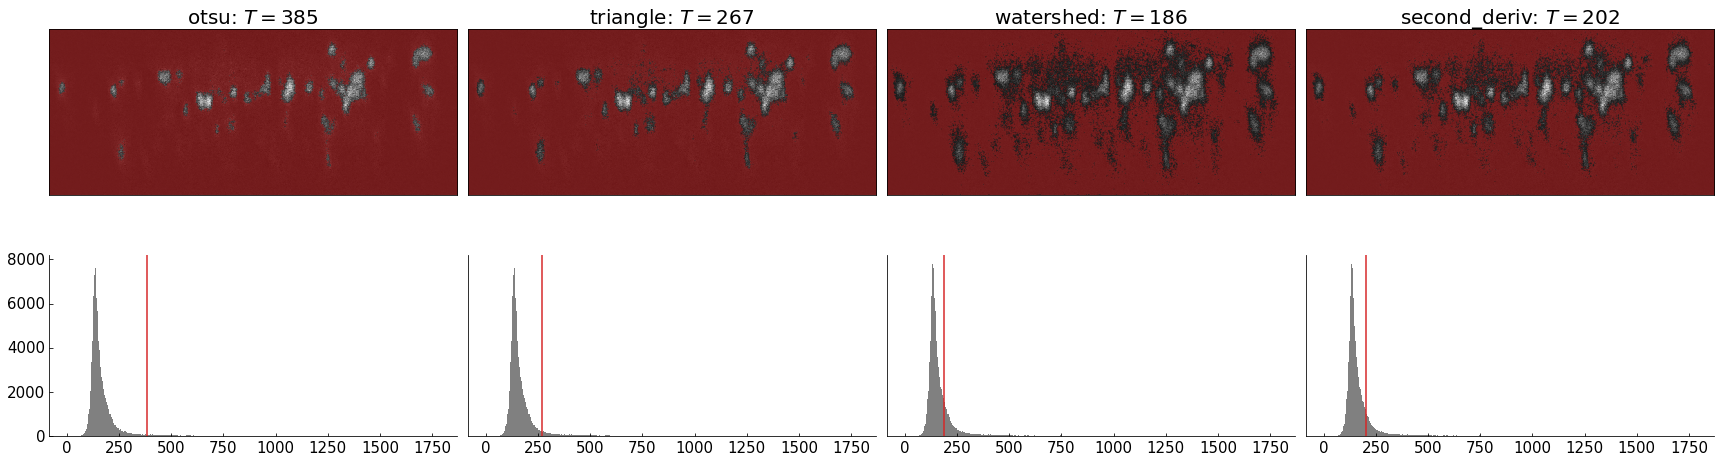

In [194]:

green = True

if green:
    path = orig_examples[0].replace('red', 'green')
else:
    path = orig_examples[0]
print(f'{path=}')
image = tiff.imread(path, key=0)
mask_color = mcolors.to_rgb(mcolors.TABLEAU_COLORS['tab:red'])

fig, axes = plt.subplots(2, len(methods),
                         figsize=(6*len(methods), 4*2),
                         subplot_kw=dict(axes_class=AA.Axes),
                         gridspec_kw=dict(height_ratios=[0.7, 0.3]),
                         sharey='row', sharex='row')

# apply thresholds
for i, meth, ax in zip(range(len(methods)), methods, axes.T):
    th = meth(image)
    title = f'{meth.__name__}: $T='f'{th:,.0f}$'.replace(',', '\'')
    print(title)
    
    ax[0].matshow(image, cmap='gray')

    alpha = 0.5
    mask = (image < th).astype(float) * alpha
    mask = np.tile(mask[..., np.newaxis], (1, 1, 4))
    mask[..., [0, 1, 2]] = mask_color
    ax[0].imshow(mask)

    for direction in ["right", "top", "bottom", "left"]:
        ax[0].axis[direction].major_ticks.set_visible(False)
        ax[0].axis[direction].major_ticklabels.set_visible(False)
    ax[0].set_title(title)

    # histogram
    for direction in ["right", "top"]:
        # hides borders
        ax[1].axis[direction].set_visible(False)
    if i > 0:
        ax[1].axis['left'].major_ticks.set_visible(False)
        ax[1].axis['left'].major_ticklabels.set_visible(False)
    # ax[1].set_yscale('log')
    ax[1].hist(image.ravel(), bins=600, color='gray')
    ax[1].axvline(th, c='tab:red')
    # ax.set_ylim(None, 1e6)
    if green:
        pass
    else:
        ax[1].set_xlim(None, 30_000)

plt.tight_layout()
if green:
    plt.savefig('report/thresholding/thresholds-green.svg')
else:
    plt.savefig('report/thresholding/thresholds.svg')
plt.show();

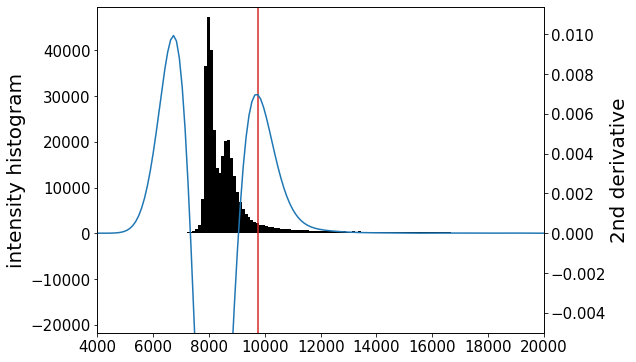

In [153]:
import cv2
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

hist, bns = np.histogram(image, bins=400)
dx = bns[1] - bns[0]
grad = (hist[1:] - hist[:-1]) / dx
grad = cv2.GaussianBlur(grad, (1, 31), 0)
grad2 = (grad[1:] - grad[:-1]) / dx
grad2 = cv2.GaussianBlur(grad2, (1, 31), 0)
coords = peak_local_max(grad2.ravel(), num_peaks=2)

i = coords.max()
T = bns[i:(i+1)].mean()

xaxis = bns.ravel()[:-1]

_, ax = plt.subplots(1,1,figsize=(8, 6))
ax.bar(xaxis, hist.ravel(), width=dx, color='black')
ax.set_ylabel('intensity histogram')
twinax = ax.twinx()
twinax.plot(xaxis[:-2], grad2.ravel(), color='tab:blue')
twinax.set_ylim(-0.005, None)
twinax.set_ylabel('2nd derivative')
ax.axvline(T, c='tab:red')
ax.set_xlim(4000, 20_000)

l1, h1 = ax.get_ylim()
l2, h2 = twinax.get_ylim()
ax.set_ylim(h1/h2 * l2, h1)

plt.savefig('report/thresholding/second-deriv.svg')
plt.show()

# Normalization

image.min()=-0.6705882352944172
gs=GridSpec(1, 2)


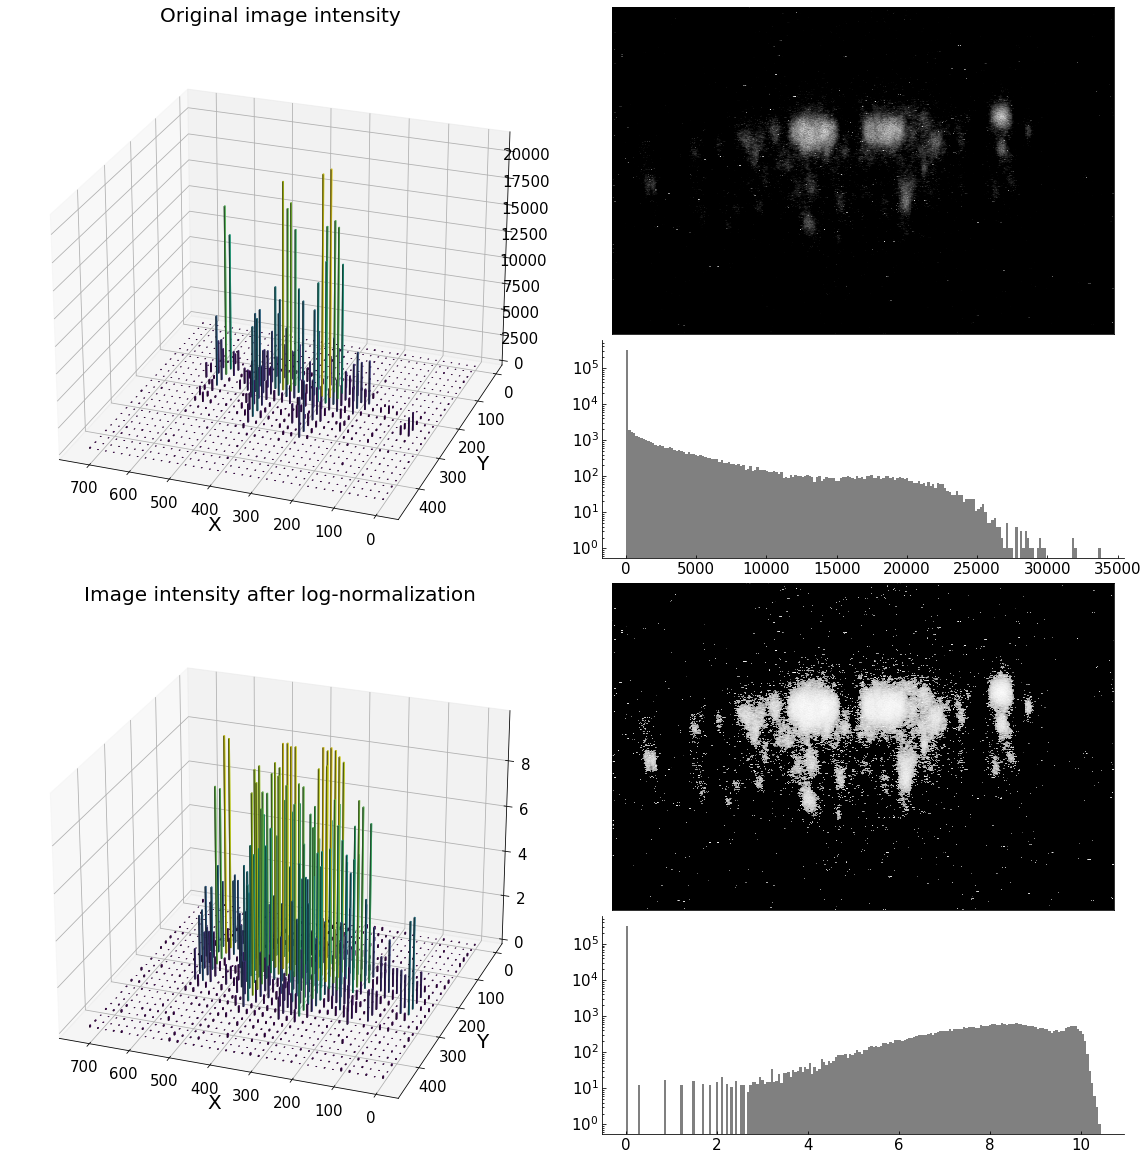

In [186]:
from stabilize2p import threshold
from stabilize2p.utils import plot_frame_values_3d
import matplotlib.gridspec as gridspec
image = tiff.imread(orig_examples[0], key=0)

os.makedirs('report/normalization', exist_ok=True)

th = threshold.triangle(image)
np.clip(image, th, None, out=image)
image = image - th
print(f'{image.min()=}')

## PLOT
fig = plt.figure(figsize=(16, 16), constrained_layout=True)

gs = gridspec.GridSpec(1, 2, figure=fig)
print(f'{gs=}')

def plot_img(fig, sub_gs):
    ax = fig.add_subplot(sub_gs[0], axes_class=AA.Axes)
    ax.matshow(image, cmap='gray')
    for direction in ["right", "top", "bottom", "left"]:
        ax.axis[direction].major_ticks.set_visible(False)
        ax.axis[direction].major_ticklabels.set_visible(False)
    ax = fig.add_subplot(sub_gs[1], axes_class=AA.Axes)
    ax.hist(image.ravel(), bins=200, color='gray')
    ax.set_yscale('log')
    for direction in ["right", "top"]:
        # hides borders
        ax.axis[direction].set_visible(False)


gs_3d = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0])
sub_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[1],
                                          height_ratios=[0.3, 0.2, 0.3, 0.2])

ax = fig.add_subplot(gs_3d[0], projection='3d')
plot_frame_values_3d(image, ax=ax, pool=20, cmap='viridis')
ax.set_title(r'Original image intensity')

plot_img(fig, sub_gs)

I = image
# l, h = I.min(), I.max()
# I = (I - l) / (h - l)
image = np.clip(np.log(1 + I), 0, None)

ax = fig.add_subplot(gs_3d[1], projection='3d')
plot_frame_values_3d(image, ax=ax, pool=20, cmap='viridis')
ax.set_title(r'Image intensity after log-normalization')

plot_img(fig, [sub_gs[2], sub_gs[3]])

plt.savefig('report/normalization/log-norm.svg')
plt.show()